# Implementation of a LIF neuron with conductance based synapses in Nengo

This notebook implemements a single population of LIF neurons with conductance based synapses as a node within a Nengo simulation.

In [4]:
%matplotlib inline

import nengo
import numpy as np
import conductance_synapses

#
# Nengo network using the code provided by conductance_synapses_tes
#

# Number of neurons in each of the simulations A, B, C
NA = NB = NC = 50

# Simulation runtime
T = 1.0
dt = 1e-4

# Input function
f = lambda t: (t - 0.5) / 0.5

# Setup the Network object
model = nengo.Network()
with model:
    # Get some fixed seed
    seedA, seedB, seedC, seed = 43, 1224, 412, 482

    # Generate three ensembles with linear connections
    a1 = nengo.Ensemble(n_neurons=NA, dimensions=1, seed=seedA)
    a2 = nengo.Ensemble(n_neurons=NA, dimensions=1, seed=seedA)
    b1 = nengo.Ensemble(n_neurons=NB, dimensions=1, seed=seedB)
    c1 = nengo.Ensemble(n_neurons=NC, dimensions=1, seed=seedC)
    con_11 = nengo.Connection(a1, b1, transform=0.5)
    con_21 = nengo.Connection(a2, b1, transform=0.5)
    con_2 = nengo.Connection(b1, c1)

    # Create a simulator in order to calculate the decoders
    with nengo.Simulator(model, seed=seed, dt=dt) as sim:
        decoder2 = sim.data[con_2].weights

    # Create a node which replaces ensemble b
    b2, cmap = conductance_synapses.transform_ensemble(b1, [con_11, con_21], sim,
                                                 use_linear_avg_pot=False,
                                                 use_conductance_synapses=True,
                                                 use_factorised_weights=False,
                                                 use_jbias=False)

    # Add another target ensemble
    c2 = nengo.Ensemble(n_neurons=NC, dimensions=1, seed=seedC)

    # Wire up the additional ensemble
    nengo.Connection(a1.neurons, b2[cmap[0]], seed=seedA, synapse=None)
    nengo.Connection(a2.neurons, b2[cmap[1]], seed=seedA, synapse=None)
    nengo.Connection(b2, c2, seed=seedA, transform=decoder2)

    # Feed some input into ensemble A
    src = nengo.Node(f)
    nengo.Connection(src, a1, seed=seedA)
    nengo.Connection(src, a2, seed=seedA)

    # Record the output for c1 and c2
    p1 = nengo.Probe(c1, "decoded_output", synapse=0.01)
    p2 = nengo.Probe(c2, "decoded_output", synapse=0.01)

    # Record the spikes of b1
    p3 = nengo.Probe(b1.neurons, "spikes")


Building finished in 0:00:01.                                                                             


In [5]:
# Run the simulation
sim = nengo.Simulator(model, seed=seed, dt=dt)
sim.run(T)

Building finished in 0:00:01.                                                                             
Simulating finished in 0:00:15.                                                                           


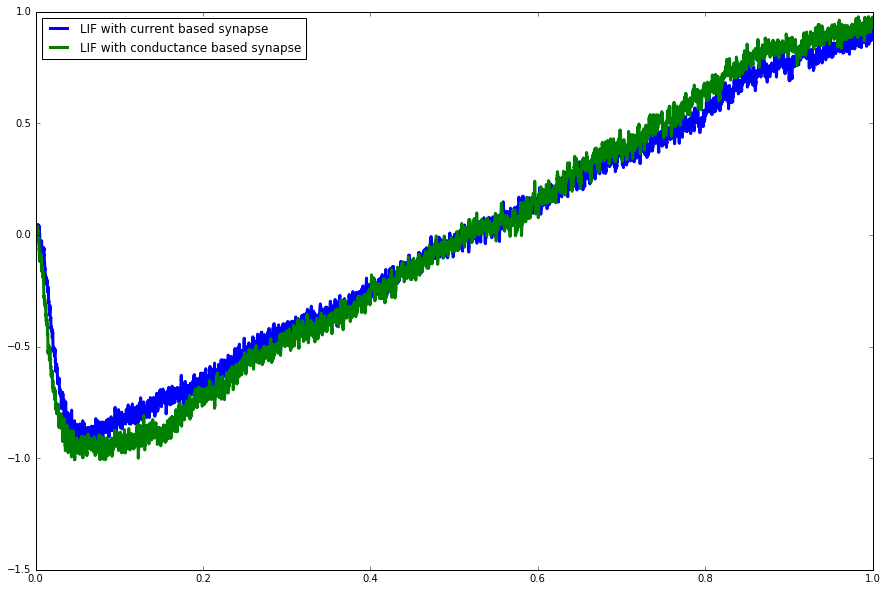

In [6]:
import matplotlib.pyplot as plt

# Plot the results
t = np.arange(0, T, 1e-4)
fig = plt.figure(figsize=(15, 10))
ax = fig.gca()
ax.plot(t, sim.data[p1], label="LIF with current based synapse", linewidth=3)
ax.plot(t, sim.data[p2], label="LIF with conductance based synapse", linewidth=3)
ax.legend(loc="best");

—————— ✁ ———————————— ✁ ———————————— ✁ ———————————— ✁ ——————

In [4]:
#
# Implementation of a population of LIF neurons with current based
# synapses as a node. In conjunction with the above code, this snippet
# can be used as a skeleton for the implementation of custom
# neuron/synapse models as a node within a Nengo simulation.
#

%matplotlib inline

import nengo
import numpy as np
import matplotlib.pyplot as plt

def sim_lif(decoder, encoder, bias, gain):
    
    # Make sure the dimensions in the input are correct
    assert(encoder.shape[0] == bias.shape[0] == gain.shape[0])
    assert(encoder.shape[1] == decoder.shape[0])
    n_neurons = encoder.shape[0]

    # Synaptic time constant
    tau_syn = 5.0e-3

    # Arrays containing the neuron/synapse state
    J_syn = np.zeros(n_neurons)
    voltage = np.zeros(n_neurons)
    refractory_time = np.zeros(n_neurons)

    def simulator(t, A):
        dt = 1e-3
        spiked = np.zeros(n_neurons)

        J_syn[...] = J_syn + dt / tau_syn * encoder @ (decoder @ A) * gain
        J = J_syn + bias
        J_syn[...] = J_syn - dt * J_syn / tau_syn
       
        nengo.LIF().step_math(dt, J, spiked, voltage, refractory_time)
        return spiked
    return simulator
